Implementation of
* `Effects of Varying Resolution on Performance of CNN based Image Classification`

Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torch import nn, optim
from torchinfo import summary
from torchmetrics import Accuracy, Precision, F1Score

Set device

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Use `transforms`:

1.   data to tensors
2.   normalize data -1 to 1


In [3]:
tf = transforms.Compose([transforms.ToTensor(),
                         transforms.Normalize( (0.5 , 0.5 , 0.5) , (0.5 , 0.5 , 0.5))])

Download Datas

In [ ]:
dataset_train = datasets.CIFAR10(root = './datas' , download=True , transform=tf , train=True)
dataset_test  = datasets.CIFAR10(root = './datas' , download=False , transform=tf , train=False)

Files already downloaded and verified


In [ ]:
classes = dict(zip(range(10) ,dataset_train.classes))
print(classes)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


Use these transforms to rescale images

In [5]:
tf08 = transforms.Resize([8,8])
tf16 = transforms.Resize([16,16])
tf32 = transforms.Resize([32,32])

Load 10 Random Data and display

In [ ]:
torch.manual_seed(15)
trainloader = DataLoader(dataset_train , 10 , shuffle = True)
data , label = next(iter(trainloader))

In [ ]:
print([classes[i.item()] for i in label])

['automobile', 'truck', 'ship', 'dog', 'ship', 'automobile', 'automobile', 'ship', 'airplane', 'deer']


In [ ]:
def plot_scale_data(data : torch.Tensor , label : torch.Tensor):
  l = len(data)
  img = torchvision.utils.make_grid(torch.concat([data,
                                                  tf32(tf16(data)),
                                                  tf32(tf08(data))]) , l)
  plt.figure(figsize=(20,15))
  plt.imshow(np.transpose(img.numpy()/2 + 0.5 , (1,2,0)))
  plt.title([classes[i.item()] for i in label])
  plt.axis('off')
  plt.show()

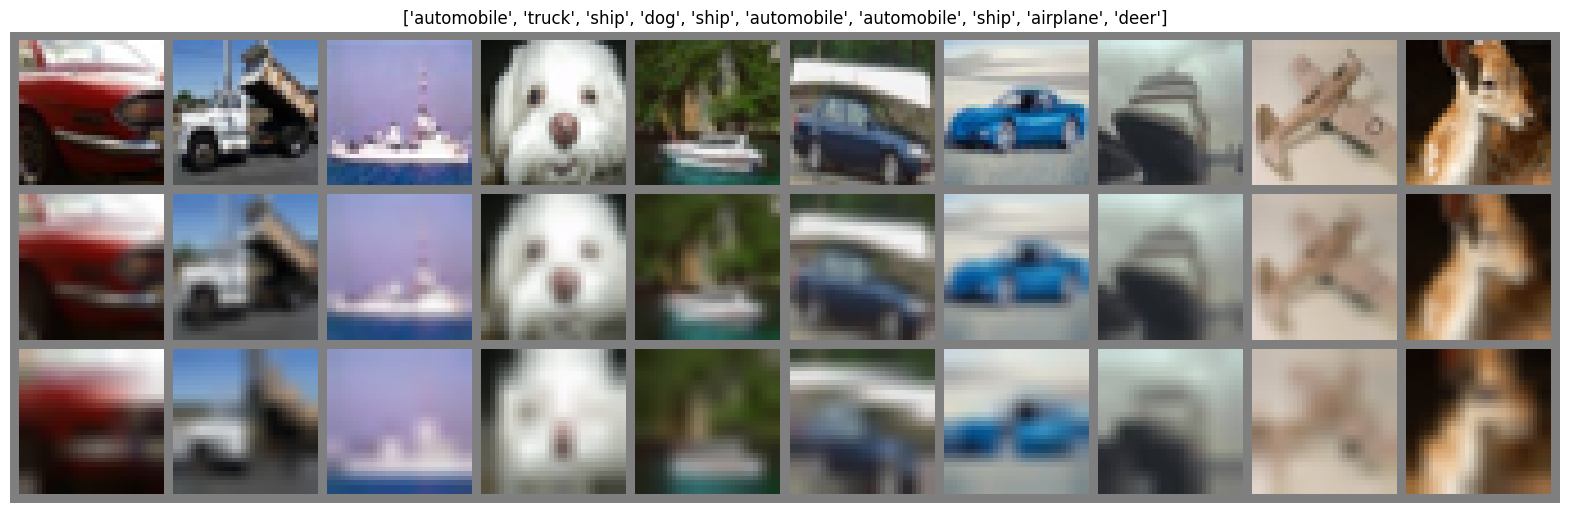

In [ ]:
plot_scale_data(data , label)

Train - Test - Validation

In [ ]:
test_size = len(dataset_test)
val_size = test_size
train_size = len(dataset_train) - val_size
train_set , val_set = random_split(dataset_train , [train_size , val_size])

In [ ]:
print(f'train set size: {len(train_set)}')
print(f'validation set size: {len(val_set)}')
print(f'test set size: {len(dataset_test)}')

train set size: 40000
validation set size: 10000
test set size: 10000


Define network

In [6]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet , self).__init__()
        self.Conv2D_1 = nn.Conv2d(3 , 32 , 3)
        self.Conv2D_2 = nn.Conv2d(32 , 32 , 3)
        self.Conv2D_3 = nn.Conv2d(32 , 32 , 3)
        self.dropout1 = nn.Dropout(0.25)
        self.Conv2D_4 = nn.Conv2d(32 , 64 , 3)
        self.Conv2D_5 = nn.Conv2d(64 , 64 , 3)
        self.Conv2D_6 = nn.Conv2d(64 , 64 , 3)
        self.dropout2 = nn.Dropout(0.25)
        self.Dence_1  = nn.Linear(64*3*3 , 512)
        self.dropout3 = nn.Dropout(0.5)
        self.Dence_2  = nn.Linear(512,10)

    def forward(self , x):
        x = torch.relu(self.Conv2D_1(x))
        x = torch.relu(self.Conv2D_2(x))
        x = torch.relu(self.Conv2D_3(x))
        x = torch.max_pool2d(x , 2)
        x = self.dropout1(x)
        #-------------------------------#
        x = torch.relu(self.Conv2D_4(x))
        x = torch.relu(self.Conv2D_5(x))
        x = torch.relu(self.Conv2D_6(x))
        x = torch.max_pool2d(x , 2)
        x = self.dropout2(x)
        x = torch.flatten(x , 1)
        #-------------------------------#
        x = torch.relu(self.Dence_1(x))
        x = self.dropout3(x)
        #-------------------------------#
        x = torch.softmax(self.Dence_2(x) , -1)
        return x

Call object `net` from `MyNet` and summarize it

In [8]:
torch.manual_seed(15)
net = MyNet().to(device=device)
summary(net , (1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
MyNet                                    [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 30, 30]           896
├─Conv2d: 1-2                            [1, 32, 28, 28]           9,248
├─Conv2d: 1-3                            [1, 32, 26, 26]           9,248
├─Dropout: 1-4                           [1, 32, 13, 13]           --
├─Conv2d: 1-5                            [1, 64, 11, 11]           18,496
├─Conv2d: 1-6                            [1, 64, 9, 9]             36,928
├─Conv2d: 1-7                            [1, 64, 7, 7]             36,928
├─Dropout: 1-8                           [1, 64, 3, 3]             --
├─Linear: 1-9                            [1, 512]                  295,424
├─Dropout: 1-10                          [1, 512]                  --
├─Linear: 1-11                           [1, 10]                   5,130
Total params: 412,298
Trainable params: 412,298
Non-traina

Loss Function and Optimizer
<br>
Train and Validation loader

In [ ]:
lr = 0.0001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr)

In [ ]:
batch_size = 32
trainloader = DataLoader(train_set , batch_size=batch_size , shuffle=True)
val_loader = DataLoader(val_set , batch_size= len(val_set) , shuffle=False)

In [ ]:
v_d , v_t = next(iter(val_loader))

Train network
<br>
Run this code 3 time with diffrent tfs

In [ ]:
loss_arr = np.array([])
val_loss_arr = np.array([])
for epoch in range(200):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        img , label = data
        img = tf32(tf08(img))

        optimizer.zero_grad()
        output = net(img.to(device))
        loss = criterion(output , label.to(device))
        loss.backward()
        optimizer.step()
        
        running_loss = loss.item() + running_loss
    with torch.no_grad():
      v_output = net(tf32(tf08(v_d)).to(device))
      val_loss = criterion(v_output , v_t.to(device))
      val_loss = val_loss.item()
    val_loss_arr = np.append(val_loss_arr , val_loss)
    loss_arr = np.append(loss_arr , running_loss)
    print(f'epoch: {epoch :3d} , R-loss: {running_loss/1250 :.3f} , V-loss: {val_loss :.3f}')
    running_loss = 0.0

epoch:   0 , R-loss: 2.217 , V-loss: 2.181
epoch:   1 , R-loss: 2.157 , V-loss: 2.133
epoch:   2 , R-loss: 2.124 , V-loss: 2.118
epoch:   3 , R-loss: 2.110 , V-loss: 2.099
epoch:   4 , R-loss: 2.096 , V-loss: 2.100
epoch:   5 , R-loss: 2.087 , V-loss: 2.089
epoch:   6 , R-loss: 2.083 , V-loss: 2.080
epoch:   7 , R-loss: 2.077 , V-loss: 2.076
epoch:   8 , R-loss: 2.070 , V-loss: 2.074
epoch:   9 , R-loss: 2.062 , V-loss: 2.069
epoch:  10 , R-loss: 2.054 , V-loss: 2.052
epoch:  11 , R-loss: 2.050 , V-loss: 2.053
epoch:  12 , R-loss: 2.042 , V-loss: 2.050
epoch:  13 , R-loss: 2.035 , V-loss: 2.037
epoch:  14 , R-loss: 2.032 , V-loss: 2.039
epoch:  15 , R-loss: 2.029 , V-loss: 2.041
epoch:  16 , R-loss: 2.021 , V-loss: 2.034
epoch:  17 , R-loss: 2.018 , V-loss: 2.024
epoch:  18 , R-loss: 2.012 , V-loss: 2.036
epoch:  19 , R-loss: 2.012 , V-loss: 2.023
epoch:  20 , R-loss: 2.007 , V-loss: 2.022
epoch:  21 , R-loss: 2.005 , V-loss: 2.017
epoch:  22 , R-loss: 1.997 , V-loss: 2.017
epoch:  23 

Plot loss - train data original

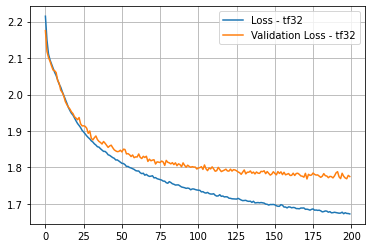

In [ ]:
plt.plot(loss_arr/1250 , label = 'Loss - tf32')
plt.plot(val_loss_arr , label = 'Validation Loss - tf32')
plt.grid()
plt.legend()
plt.show()

Plot loss - train data 16×16

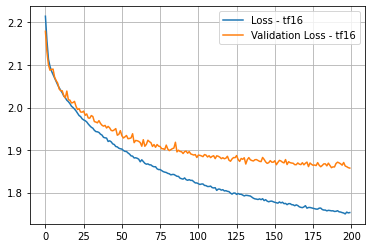

In [ ]:
plt.plot(loss_arr/1250 , label = 'Loss - tf16')
plt.plot(val_loss_arr , label = 'Validation Loss - tf16')
plt.grid()
plt.legend()
plt.show()

Plot loss - train data 8×8

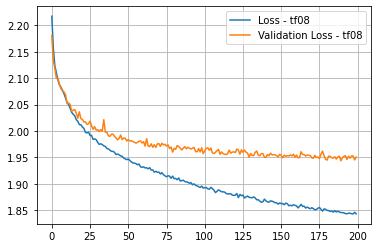

In [ ]:
plt.plot(loss_arr/1250 , label = 'Loss - tf08')
plt.plot(val_loss_arr , label = 'Validation Loss - tf08')
plt.grid()
plt.legend()
plt.show()

Save Model

In [ ]:
path = './cifar_net08.pth'
torch.save(net.state_dict() , path)

Load Models

In [ ]:
path32 = './cifar_net32.pth'
path16 = './cifar_net16.pth'
path08 = './cifar_net08.pth'


net32 = MyNet().to(device)
net32.load_state_dict(torch.load(path32 , map_location=device))

net16 = MyNet().to(device)
net16.load_state_dict(torch.load(path16 , map_location=device))

net08 = MyNet().to(device)
net08.load_state_dict(torch.load(path08 , map_location=device))

<All keys matched successfully>

Ignore dropout layers for test

In [ ]:
net32.eval();
net16.eval();
net08.eval();

Load test data

In [ ]:
testloader = DataLoader(dataset_test , len(dataset_test) , shuffle=False)
img_t , label_t = next(iter(testloader))

Test datas: 32 , 16 , 08

In [ ]:
label_t = label_t.to(device)
img_t32 = img_t.to(device)
img_t16 = tf32(tf16(img_t)).to(device)
img_t08 = tf32(tf08(img_t)).to(device)

##### C : Trained on original resolution dataset (32x32) and tested on varying resolution dataset (32x32, 16x16, 8x8)

In [ ]:
with torch.no_grad():
  tp_32 = torch.argmax(net32(img_t32) , 1)
  tp_16 = torch.argmax(net32(img_t16) , 1)
  tp_08 = torch.argmax(net32(img_t08) , 1)

Metrics

In [ ]:
accuracy_score = Accuracy()
precision_score = Precision(average='macro', num_classes=10)
f1_score = F1Score(num_classes=10)

In [ ]:
accuracy32 = accuracy_score(tp_32.cpu() , label_t)
accuracy16 = accuracy_score(tp_16.cpu() , label_t)
accuracy08 = accuracy_score(tp_08.cpu() , label_t)

In [ ]:
precision32 = precision_score(tp_32.cpu() , label_t)
precision16 = precision_score(tp_16.cpu() , label_t)
precision08 = precision_score(tp_08.cpu() , label_t)

In [ ]:
f1_32 = f1_score(tp_32.cpu() , label_t)
f1_16 = f1_score(tp_16.cpu() , label_t)
f1_08 = f1_score(tp_08.cpu() , label_t)

In [ ]:
metrics32 = torch.stack([accuracy32 , precision32 , f1_32])
metrics16 = torch.stack([accuracy16 , precision16 , f1_16])
metrics08 = torch.stack([accuracy08 , precision08 , f1_08])

In [ ]:
metrics = torch.stack([metrics32 , metrics16 , metrics08])

In [ ]:
print(metrics)

tensor([[0.7148, 0.7109, 0.7148],
        [0.4517, 0.5984, 0.4517],
        [0.2881, 0.5115, 0.2881]])


##### D : Trained and tested on each varying resolution dataset separately (32x32, 16x16, 8x8)

In [ ]:
with torch.no_grad():
  tp_32 = torch.argmax(net32(img_t32) , 1)
  tp_16 = torch.argmax(net16(img_t16) , 1)
  tp_08 = torch.argmax(net08(img_t08) , 1)

Metrics

In [ ]:
accuracy32 = accuracy_score(tp_32.cpu() , label_t)
accuracy16 = accuracy_score(tp_16.cpu() , label_t)
accuracy08 = accuracy_score(tp_08.cpu() , label_t)

In [ ]:
precision32 = precision_score(tp_32.cpu() , label_t)
precision16 = precision_score(tp_16.cpu() , label_t)
precision08 = precision_score(tp_08.cpu() , label_t)

In [ ]:
f1_32 = f1_score(tp_32.cpu() , label_t)
f1_16 = f1_score(tp_16.cpu() , label_t)
f1_08 = f1_score(tp_08.cpu() , label_t)


In [ ]:
metrics32 = torch.stack([accuracy32 , precision32 , f1_32])
metrics16 = torch.stack([accuracy16 , precision16 , f1_16])
metrics08 = torch.stack([accuracy08 , precision08 , f1_08])

In [ ]:
metrics = torch.stack([metrics32 , metrics16 , metrics08])

In [ ]:
print(metrics)

tensor([[0.7148, 0.7109, 0.7148],
        [0.6311, 0.6297, 0.6311],
        [0.5526, 0.5517, 0.5526]])
